In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal
import matplotlib.pyplot as pt
%matplotlib inline
import time
from IPython import display

In [2]:
def generate_data(n_data,mu1,mu2,cov1,cov2,seed1=24,seed2=42):
    data1_true = multivariate_normal.rvs(mean=mu1_true,cov=cov1_true,size=n_data, random_state=24)
    data2_true = multivariate_normal.rvs(mean=mu2_true,cov=cov2_true,size=n_data, random_state=42)
    data = np.concatenate((data1_true,data2_true))

    return data1_true,data2_true,data

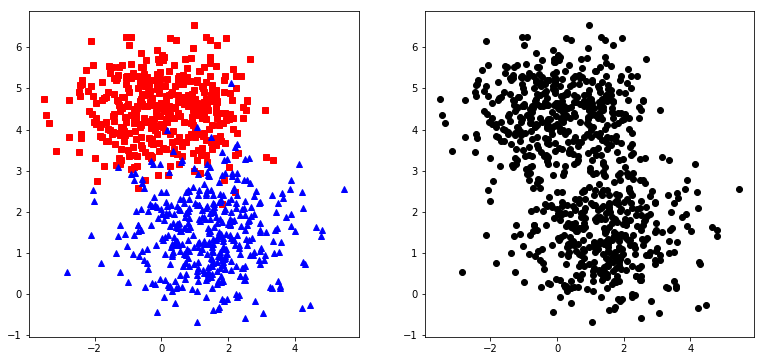

In [3]:
npr.seed(48)

mu1_true = npr.rand(2)*5
mu2_true = npr.rand(2)*5

var1_true = npr.rand(2)*2
var2_true = npr.rand(2)*2

corr1_true = np.array([[1,0],[0,1]])
corr2_true = np.array([[1,0],[0,1]])
corr1_true[0,1] = corr1_true[1,0] = 2*np.random.rand(1)-1
corr2_true[0,1] = corr2_true[1,0] = 2*np.random.rand(1)-1

cov1_true = corr1_true*np.sqrt(np.outer(var1_true,var1_true))
cov2_true = corr2_true*np.sqrt(np.outer(var2_true,var2_true))

data1_true,data2_true,data = generate_data(400,mu1_true,mu2_true,cov1_true,cov2_true)

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.subplot(1,2,2)
pt.plot(data[:,0],data[:,1],'ko')
pt.show()

lnprob1_true = multivariate_normal.logpdf(data1_true,mean=mu1_true,cov=cov1_true)
lnprob2_true = multivariate_normal.logpdf(data2_true,mean=mu2_true,cov=cov2_true)
lnprob_true = np.sum(lnprob1_true)+np.sum(lnprob2_true)

In [4]:
x_plot = np.arange(-4,8,0.5)
y_plot = np.arange(-4,8,0.5)

xx_plot, yy_plot = np.meshgrid(x_plot,y_plot)
xy_plot = np.stack((xx_plot,yy_plot),axis=-1)

lnprob1_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_true,cov=cov1_true)
lnprob2_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_true,cov=cov2_true)

In [5]:
def expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new):

    mu1_old = np.array([0,0])
    mu2_old = np.array([0,0])
    cov1_old = np.array([[0,0],[0,0]])
    cov2_old = np.array([[0,0],[0,0]])
    
    total_diff = (np.sum(np.abs(mu1_new-mu1_old))
                 +np.sum(np.abs(mu2_new-mu2_old))
                 +np.sum(np.abs(cov1_new-cov1_old))
                 +np.sum(np.abs(cov2_new-cov2_old)))

    n_iteration = 0

    while total_diff>1e-5:

        mu1_old = mu1_new+0
        mu2_old = mu2_new+0
        cov1_old = cov1_new+0
        cov2_old = cov2_new+0
    
        lnprob1 = multivariate_normal.logpdf(data,mean=mu1_old,cov=cov1_old)
        lnprob2 = multivariate_normal.logpdf(data,mean=mu2_old,cov=cov2_old)
    
        condition_data1 = lnprob1>=lnprob2
    
        data1 = data[condition_data1,:]
        data2 = data[~condition_data1,:]
    
        lnprob1_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_old,cov=cov1_old)
        lnprob2_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_old,cov=cov2_old)
        
        lnprob1 = multivariate_normal.logpdf(data1,mean=mu1_old,cov=cov1_old)
        lnprob2 = multivariate_normal.logpdf(data2,mean=mu2_old,cov=cov2_old)
        lnprob = np.sum(lnprob1)+np.sum(lnprob2)

        pt.figure(1,figsize=(13,6))
        pt.clf()

        pt.subplot(1,2,1)
        pt.title('iteration %d: sum of log probability = %.5e'%(n_iteration,lnprob))
        pt.contourf(x_plot,y_plot,lnprob1_plot,cmap='Reds',levels=5,alpha=1)
        pt.contourf(x_plot,y_plot,lnprob2_plot,cmap='Blues',levels=5,alpha=0.6)
        pt.plot(data1[:,0],data1[:,1],'rs',alpha=0.6)
        pt.plot(data2[:,0],data2[:,1],'b^',alpha=0.6)
    
        pt.subplot(1,2,2)
        pt.title('truth: sum of log probability = %.5e'%(lnprob_true))
        pt.contourf(x_plot,y_plot,lnprob1_true_plot,cmap='Reds',levels=5,alpha=1)
        pt.contourf(x_plot,y_plot,lnprob2_true_plot,cmap='Blues',levels=5,alpha=0.6)
        pt.plot(data1_true[:,0],data1_true[:,1],'rs',alpha=0.6)
        pt.plot(data2_true[:,0],data2_true[:,1],'b^',alpha=0.6)
    
        display.display(pt.gcf())
        display.clear_output(wait=True)
    
        mu1_new = np.mean(data1,axis=0)
        mu2_new = np.mean(data2,axis=0)
    
        cov1_new = np.cov(data1.T,ddof=1)
        cov2_new = np.cov(data2.T,ddof=1)

        total_diff = (np.sum(np.abs(mu1_new-mu1_old))
                     +np.sum(np.abs(mu2_new-mu2_old))
                     +np.sum(np.abs(cov1_new-cov1_old))
                     +np.sum(np.abs(cov2_new-cov2_old)))
    
        n_iteration = n_iteration+1

        time.sleep(0.2)

    return n_iteration,condition_data1,mu1_old,mu2_old,cov1_old,cov2_old,lnprob

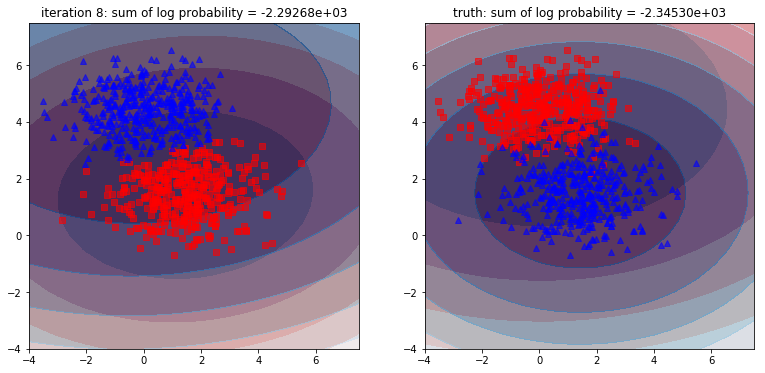

In [6]:
npr.seed(84)

mu1_new = npr.rand(2)*5
mu2_new = npr.rand(2)*5

var1_new = npr.rand(2)*2
var2_new = npr.rand(2)*2

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])
corr1_new[0,1] = corr1_new[1,0] = 2*np.random.rand(1)-1
corr2_new[0,1] = corr2_new[1,0] = 2*np.random.rand(1)-1

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)

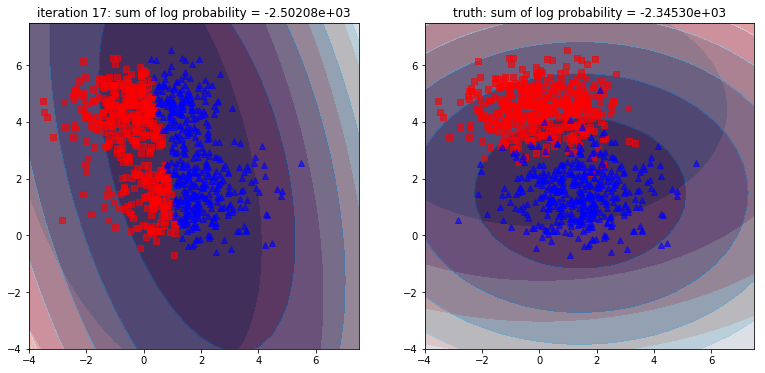

In [7]:
mu1_new = np.array([-2,2])
mu2_new = np.array([4,4])

var1_new = np.array([1,1])
var2_new = np.array([1,1])

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)

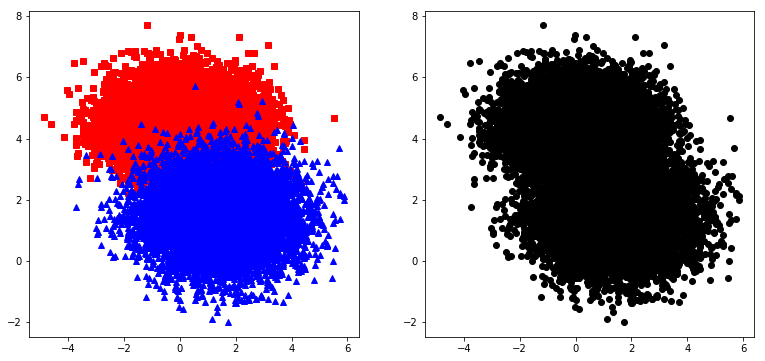

In [8]:
data1_true,data2_true,data = generate_data(10000,mu1_true,mu2_true,cov1_true,cov2_true)

pt.figure(1,figsize=(13,6))
pt.subplot(1,2,1)
pt.plot(data1_true[:,0],data1_true[:,1],'rs')
pt.plot(data2_true[:,0],data2_true[:,1],'b^')
pt.subplot(1,2,2)
pt.plot(data[:,0],data[:,1],'ko')
pt.show()

lnprob1_true = multivariate_normal.logpdf(data1_true,mean=mu1_true,cov=cov1_true)
lnprob2_true = multivariate_normal.logpdf(data2_true,mean=mu2_true,cov=cov2_true)
lnprob_true = np.sum(lnprob1_true)+np.sum(lnprob2_true)

x_plot = np.arange(-6,10,0.5)
y_plot = np.arange(-6,10,0.5)

xx_plot, yy_plot = np.meshgrid(x_plot,y_plot)
xy_plot = np.stack((xx_plot,yy_plot),axis=-1)

lnprob1_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu1_true,cov=cov1_true)
lnprob2_true_plot = multivariate_normal.logpdf(xy_plot,mean=mu2_true,cov=cov2_true)

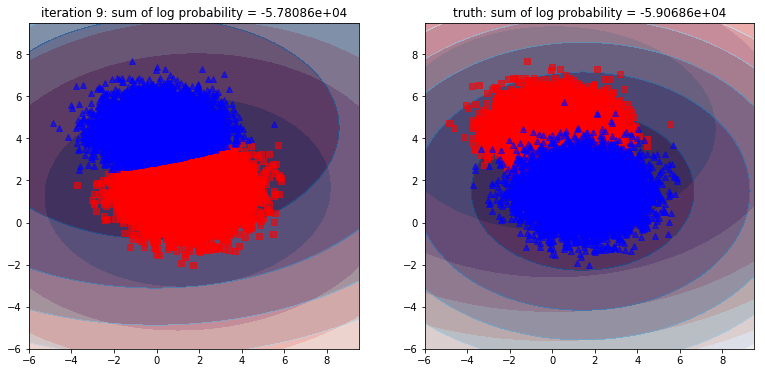

In [9]:
npr.seed(84)

mu1_new = npr.rand(2)*5
mu2_new = npr.rand(2)*5

var1_new = npr.rand(2)*2
var2_new = npr.rand(2)*2

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])
corr1_new[0,1] = corr1_new[1,0] = 2*np.random.rand(1)-1
corr2_new[0,1] = corr2_new[1,0] = 2*np.random.rand(1)-1

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)

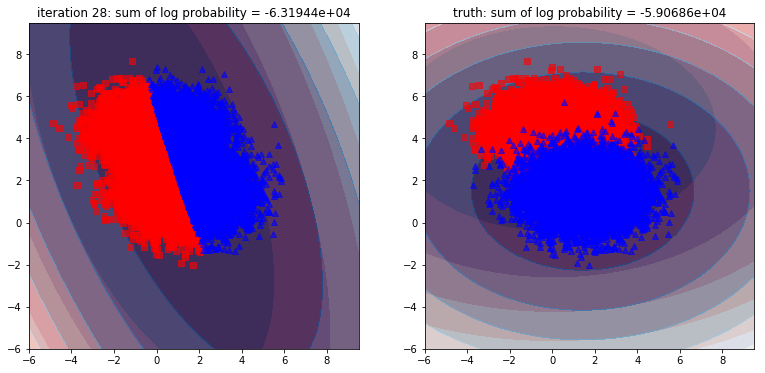

In [10]:
mu1_new = np.array([-2,2])
mu2_new = np.array([4,4])

var1_new = np.array([1,1])
var2_new = np.array([1,1])

corr1_new = np.array([[1,0],[0,1]])
corr2_new = np.array([[1,0],[0,1]])

cov1_new = corr1_new*np.sqrt(np.outer(var1_new,var1_new))
cov2_new = corr2_new*np.sqrt(np.outer(var2_new,var2_new))

n_iteration,condition_data1,mu1_new,mu2_new,cov1_new,cov2_new,lnprob = expectation_maximization(mu1_new,mu2_new,cov1_new,cov2_new)